In [1]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import load_model
from common_variables import *

/Users/tahaatiq/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
pred_interval = 128 # Predict every n minutes
pred_size = 30 # Prediction length into the future
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
df = pd.read_csv(test_time_series_path, dayfirst = True, index_col=['Date'], parse_dates=['Date'], usecols=['Date','HLAvg','MA','Returns'])[-batch_size*40:]

/var/folders/wy/tcd919h11l33h541fh7w9dd80000gn/T/ipykernel_44262/725843854.py:1: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df = pd.read_csv(test_time_series_path, dayfirst = True, index_col=['Date'], parse_dates=['Date'], usecols=['Date','HLAvg','MA','Returns'])[-batch_size*40:]


In [5]:
scaler = joblib.load(scaler_path)
scaler.clip = False  # Manually set the clip attribute
df['Scaled'] = scaler.transform(df[['Returns']].values)


/Library/Python/3.9/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.23.1 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [6]:
model = load_model(model_path)

In [7]:
scaled = df['Scaled'].values

# Create empty column to store the multi predictions
df["Pred_Close_From"] =  np.nan
df["Pred_Close_To"] = np.nan

# Cache the column indices 
pred_close_from_col_index = df.columns.get_loc('Pred_Close_From')
pred_close_to_col_index = df.columns.get_loc('Pred_Close_To')

ma_col_index = df.columns.get_loc('MA')
predictions_for_plot = []
df_len = df.shape[0]
for i in range(window_size, df_len - pred_size, pred_interval):
    X = [scaled[i-window_size:i]]
    y = []
    y_ma = df.iloc[i - 1, ma_col_index]
    for _ in range(pred_size):
        X = np.asarray(X)
        X = np.reshape(X, (1, window_size, 1))
        y_pred_scaled = model.predict(X)
        y_return = scaler.inverse_transform(y_pred_scaled)
        #y_ma = y_ma * (1 + y_return) # Arithmetic Returns
        y_ma = y_ma * np.exp(y_return) # Log Returns
        y.append(float(y_ma))
        # Remove first item in the list
        X = np.delete(X, 0)
        # Add the new prediction to the end
        X = np.append(X, y_pred_scaled)

    df.iloc[i, pred_close_from_col_index] = y[0]
    df.iloc[i, pred_close_to_col_index] = y[-1]
    y_padded = np.pad(y, (i, df_len - pred_size - i), mode='constant', constant_values=np.nan)
    df_plot = pd.Series(data=y_padded,index=df.index)

    predictions_for_plot.append(df_plot)

df

1/1 [==============================] - 0s 18ms/step


,HLAvg,MA,Returns,Scaled,Pred_Close_From,Pred_Close_To
Date,,,,,,
2023-12-01 00:39:00,1.263930,1.263915,0.000005,0.610385,NaN,NaN
2023-12-01 00:40:00,1.263845,1.263912,-0.000002,0.609193,NaN,NaN
2023-12-01 00:41:00,1.263930,1.263919,0.000005,0.610385,NaN,NaN
2023-12-01 00:42:00,1.263980,1.263928,0.000007,0.610852,NaN,NaN
2023-12-01 00:43:00,1.264000,1.263941,0.000010,0.611370,NaN,NaN
...,...,...,...,...,...,...
2023-12-01 21:55:00,1.270935,1.270822,0.000001,0.609762,NaN,NaN
2023-12-01 21:56:00,1.271035,1.270829,0.000006,0.610587,NaN,NaN
2023-12-01 21:57:00,1.271040,1.270834,0.000004,0.610226,NaN,NaN


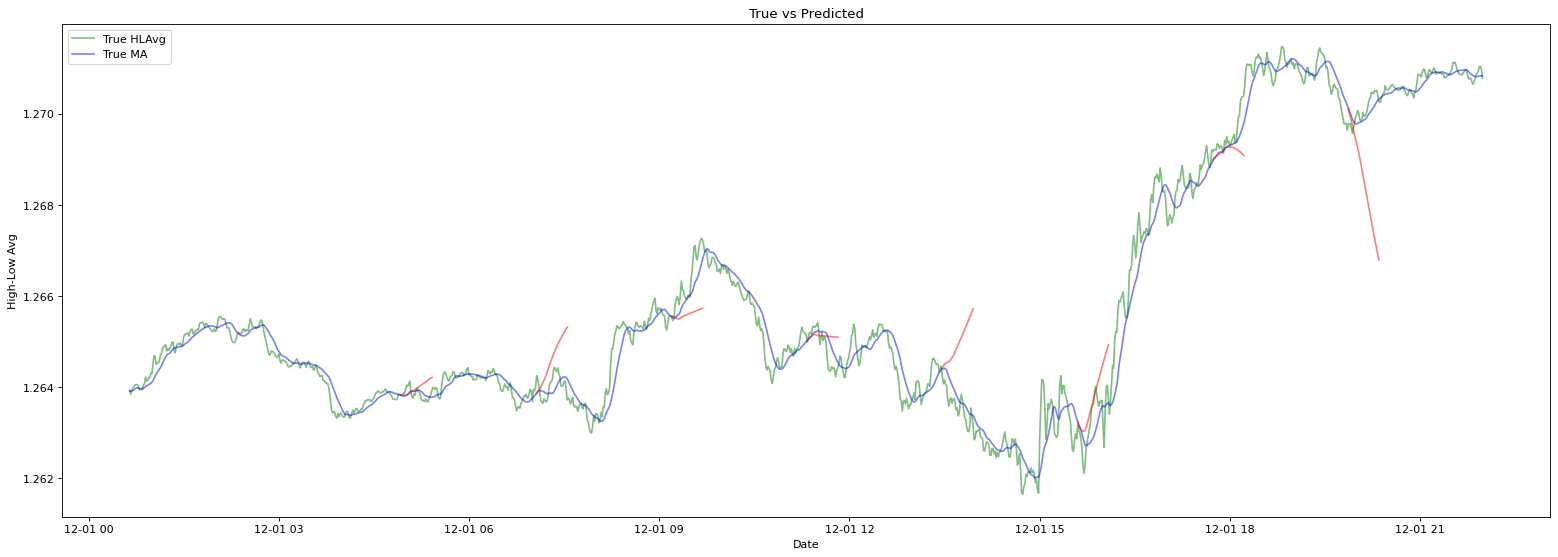

In [10]:
plt.figure(figsize=(24, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df['HLAvg'], color = 'green', label = 'True HLAvg', alpha=0.5)
plt.plot(df['MA'], color = 'blue', label = 'True MA', alpha=0.5)
for i in range(len(predictions_for_plot)):
    plt.plot(predictions_for_plot[i], color = 'red', alpha=0.5)
plt.title('True vs Predicted')
plt.xlabel('Date')
plt.ylabel('High-Low Avg')
plt.legend()
plt.show()